In [16]:
from __future__ import print_function

import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from torchvision import models
from IPython.display import HTML
import time

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)

# Seed() method used to initialise a random number generator
# The random number generator requires a number to start with (seed value) to be able to generate a random number
# If you the same seed value you'll get the same set of random numbers
random.seed(manualSeed)

# Sets the seed for randomly generating values with pytorch
# TODO where is this used
torch.manual_seed(manualSeed)

Random Seed:  999


In [17]:
### Dataroots for the different datasets
## Celeba Dataset: 
# dataset_name = "celeba"
# dataroot = "/home/a/Projects/dggan-pytorch-2d-images/data/celeba/"

## Scan The World main dataset:
# dataset_name = "scan-the-world-main-images"
# dataroot = "/home/a/Projects/dggan-pytorch-2d-images/data/scan-the-world-main-images/"

## 2D Scan The World busts dataset: 
# dataset_name = "scan-the-world-busts-images"
# dataroot = "/home/a/Projects/dggan-pytorch-2d-images/data/scan-the-world-busts-images/"

## Mixed god dataset:
# dataset_name = "mixed-gods"
# dataroot = "/home/a/Projects/dggan-pytorch-2d-images/data/mixed-gods/"

# Sanitised mixed god dataset
# dataset_name = "sanitised-mixed-gods"
# dataroot = "/home/a/Projects/dggan-pytorch-2d-images/data/sanitised-mixed-gods/"

# Sanitised mixed god dataset
# dataset_name = "sanitised-mixed-gods-scan-the-world"
# dataroot = "/home/a/Projects/dggan-pytorch-2d-images/data/sanitised-mixed-gods-scan-the-world/"

# Unsanitised full dataset
# dataset_name = "unsanitised-full-dataset"
# dataroot = "/home/a/Projects/dggan-pytorch-2d-images/data/all-scan-the-world-images/"

# # Facial recognition full dataset
# dataset_name = "facerecog-recog-full-dataset"
# dataroot = "/home/a/Projects/dggan-pytorch-2d-images/data/facerecog-all-scan-the-world/"

# Tags classifier - busts
# dataset_name = "tags-classifier-fullbody"
# dataroot = "/home/a/Projects/dggan-pytorch-2d-images/data/busts-tags-classifier/"
    
# Tags classifier - fullbody
dataset_name = "tags-classifier-fullbody-label-smoothing-flip-d-labels"
dataroot = "/home/a/Projects/dggan-pytorch-2d-images/data/fullbody-tags-classifier/"

workers = 2 
batch_size = 128
image_size = 64 
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 100
lr = 0.0002
beta1 = 0.5
ngpu = 1

In [18]:
# Make output directory
results_dir = "results_" + dataset_name + "_epochs_" + str(num_epochs) + "_" + time.strftime("%Y%m%d-%H%M%S")
path = os.path.join("/home/a/Projects/dggan-pytorch-2d-images/outputs", results_dir)
os.mkdir(path)

Size of the dataset:  13708


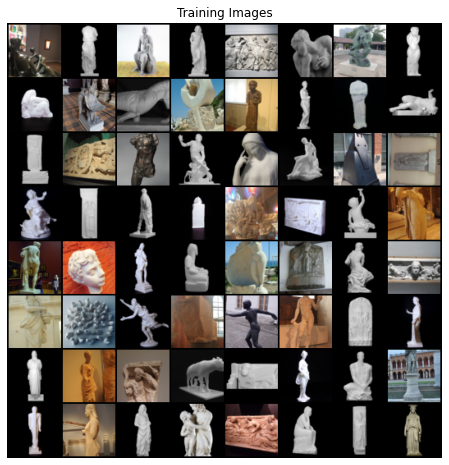

In [19]:
# Create dataset by standardising and normalizing the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# Create the dataloader - python iterable over the dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

dataset_size = len(dataloader.dataset)
print("Size of the dataset: ", dataset_size)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images before any training has begun
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [20]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [21]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            # state size. (ngf*8) x 4 x 4          
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            # state size. (ngf*2) x 16 x 16
            
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            
            
            
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [22]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [23]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
        
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [24]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [25]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [28]:
# randomly flip some labels
def flip_labels_randomly(label, percentage):
    # number of labels to flip
    num_label_flip = int(percentage * label.shape[0])
    # choose labels to flip
    label_flip = np.random.choice([i for i in range(label.shape[0])], size=num_label_flip)
    # invert the labels in place
    label[label_flip] = 1 - label[label_flip]
    return label

In [29]:
import csv
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
D_fake_losses = []
D_real_losses = []
D_x_acc = []
D_G_z1_acc = []
D_G_z2_acc = []
iters = 0

wtr = csv.writer(open (os.path.join(path,'training_stats.csv'), 'w', newline=''))
wtr.writerow(["Current Epoch", "Total number of epochs", "Iteration", "Batch_size", "D_losses", "D_fake_losses", "D_real_losses", "G_losses", "D_accuracy", "D_G_z1_accurancy", "D_G_z2_accuracy"])
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        label = flip_labels_randomly(label, 0.05)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        label = flip_labels_randomly(label, 0.05)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output - note this is loss on fake 
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_D_fake: %.4f\tLoss_D_real: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errD_fake.item(), errD_real.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            wtr.writerow([epoch, num_epochs, i, len(dataloader), errD.item(), errD_fake.item(), errD_real.item(), errG.item(), D_x, D_G_z1, D_G_z2])

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        D_fake_losses.append(errD_fake.item())
        D_real_losses.append(errD_real.item())
        D_x_acc.append(D_x)
        D_G_z1_acc.append(D_G_z1)
        D_G_z2_acc.append(D_G_z2)
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/100][0/108]	Loss_D: 1.7737	Loss_D_fake: 1.0588	Loss_D_real: 0.7148	Loss_G: 5.0461	D(x): 0.5516	D(G(z)): 0.6054 / 0.0104


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(20,10))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.plot(D_fake_losses,label="D_fake")
plt.plot(D_real_losses,label="D_real")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(os.path.join(path,"generator_discriminator_losses.png"))

In [ ]:
plt.figure(figsize=(20,10))
plt.title("Discriminator Accuracy During Training")
plt.plot(D_x_acc,label="D_acc")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(os.path.join(path,"discriminator_accuracy.png"))

In [ ]:
from scipy import stats


d_losses_mode = stats.mode(D_losses)
d_fake_losses_mode = stats.mode(D_fake_losses)
d_real_losses_mode = stats.mode(D_real_losses)
g_losses_mode = stats.mode(G_losses)

f = open(os.path.join(path,"overall_stats.txt"), "a")
f.write("Dataset: \t" + dataset_name +"\n")
f.write("Dataset size: \t" + str(dataset_size) +"\n")
f.write("D_losses mean: \t" + str(np.mean(D_losses)) +"\n")
f.write("D_losses mode: \t" + str(d_losses_mode.mode[0]) +"\n")
f.write("D_fake_losses mean: \t" + str(np.mean(D_fake_losses)) +"\n")
f.write("D_fake_losses mode: \t" + str(d_fake_losses_mode.mode[0]) +"\n")
f.write("D_real_losses mean: \t" + str(np.mean(D_real_losses)) +"\n")
f.write("D_real_losses mode: \t" + str(d_real_losses_mode.mode[0]) +"\n")
f.write("G_losses mean: \t" + str(np.mean(G_losses)) +"\n")
f.write("G_losses mode: \t" + str(g_losses_mode.mode[0]) +"\n")
f.write("Discriminator accuracy mean \t" + str(np.mean(D_x_acc)))

f.close()

In [ ]:
# Animation of generations over time

#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.savefig(os.path.join(path,"real_vs_fake_images.png"))

In [ ]:
from torchvision.utils import save_image

gen_img_dir = os.path.join(path, "generated_images")
if not os.path.exists(gen_img_dir):
    os.mkdir(gen_img_dir)
im_batch_size = 64
n_images=100
for i_batch in range(0, n_images, im_batch_size):
    gen_images = netG(fixed_noise)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join(gen_img_dir, f'image_{i_batch+i_image:05d}.png'))

In [ ]:
from zipfile import ZipFile
from os.path import basename


zip_file = "/home/a/Projects/dggan-pytorch-2d-images/outputs/" + results_dir + ".zip"
with ZipFile(zip_file, 'w') as zipObj:
   # Iterate over all the files in directory
   for folderName, subfolders, filenames in os.walk(path):
       for filename in filenames:
           #create complete filepath of file in directory
           filePath = os.path.join(folderName, filename)
           # Add file to zip
           zipObj.write(filePath, basename(filePath))